In [1]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score, adjusted_rand_score
import networkx as nx
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns


from libraries.preprocess import load_ts_dataset, distance_matrix, epsilon_graph_hard, epsilon_graph_mean
from libraries.clustering_algos import kmeans, gaussian_mixture, spectral_clustering
from libraries.nmf import nmf_sklearn


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
MAX_LEN = 100

In [4]:
# import dataset
data_normal = pd.read_csv('ptbdb_normal.csv').iloc[:MAX_LEN].to_numpy()
data_abnormal = pd.read_csv('ptbdb_abnormal.csv').iloc[:MAX_LEN].to_numpy()
data = np.concatenate([data_normal, data_abnormal], axis=0)

true_labels = np.concatenate([np.zeros(MAX_LEN), np.ones(MAX_LEN)])

ts_length = len(data[0])
# suffle dataset
shuffl = np.concatenate([data, np.expand_dims(true_labels, axis=1)], axis=1)
np.random.shuffle(shuffl)

data, true_labels = shuffl[:, :ts_length - 1], shuffl[:, -1].astype(np.int64)

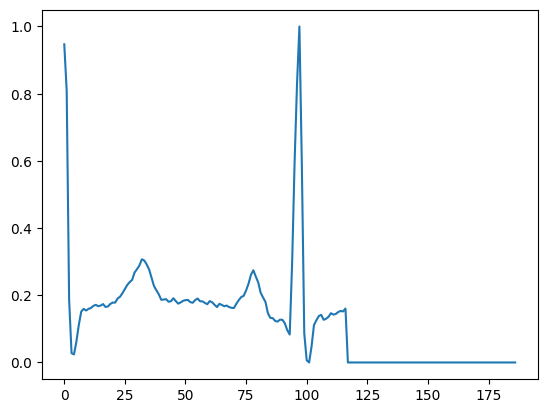

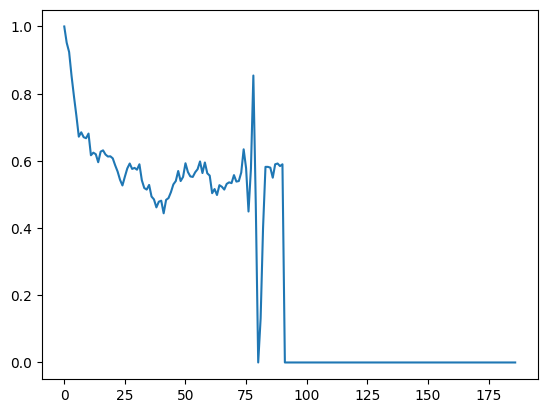

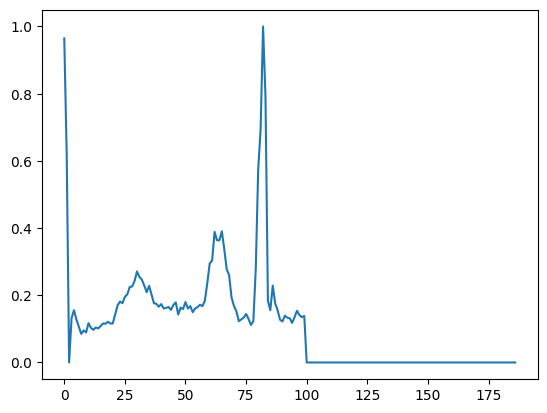

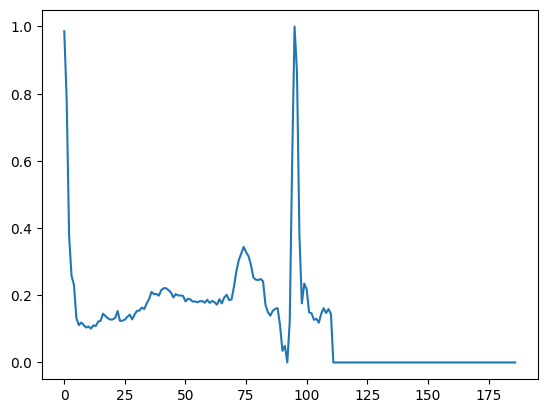

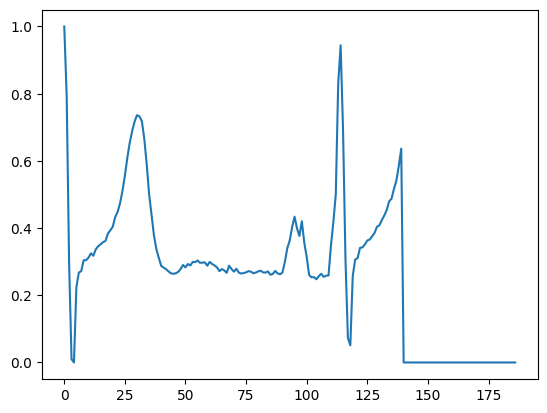

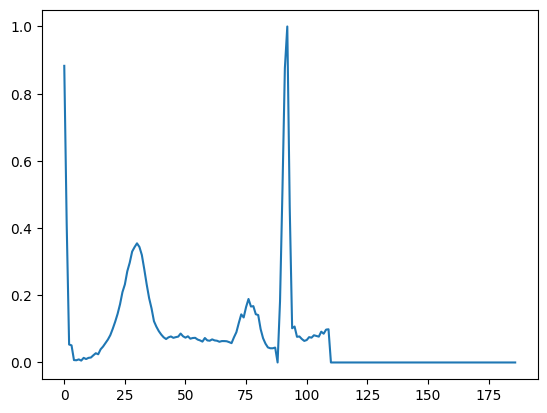

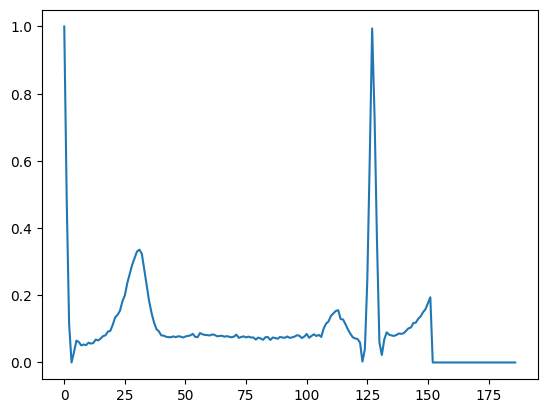

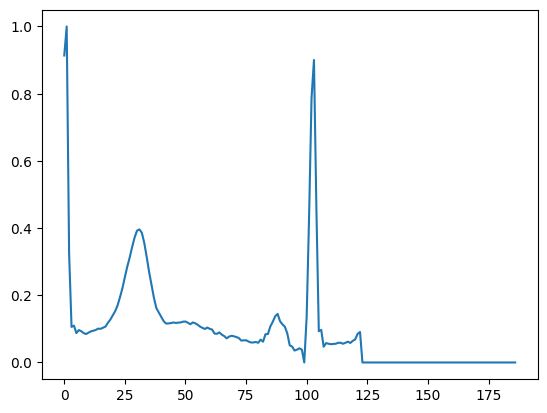

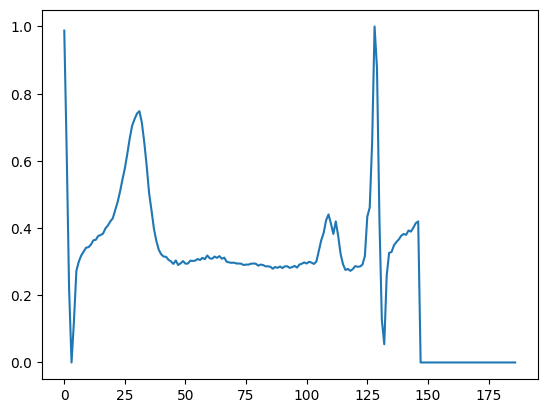

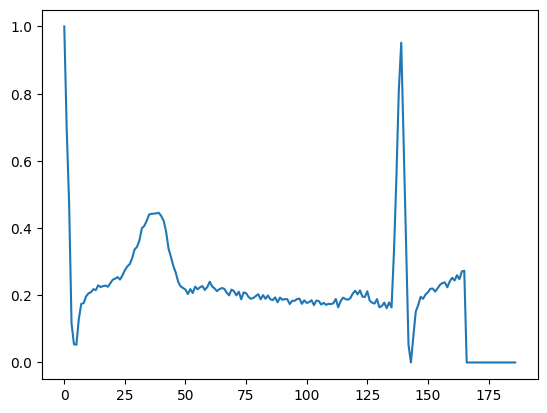

In [5]:
idx = 0
for idx in range(3):
    plt.plot(data[idx])
    plt.title(f'Example sample n°{idx}')
    plt.show()

In [6]:
def add_noise(data, sigma=0.01):
    noise = np.random.normal(0, sigma, np.shape(data))
    return data + noise

def add_outliers(data, outlier_magnitude=0.5):
    outliers = np.random.binomial(1, p=0.01, size=np.shape(data)) * np.random.random(size=np.shape(data)) * outlier_magnitude
    return data + outliers
    

In [7]:
# We search the optimal epsilon for the dataset-method combination
eps = []
factor = 0.90
residuals = []
rands = []
preds = []

dist = distance_matrix(data)
dist_n = dist / np.max(dist)

for i in range(50):
    ep = factor**i
    eps.append(ep)
    Anp = epsilon_graph_hard(dist_n, epsilon=ep)
    W, H, residual = nmf_sklearn(Anp, d=2, max_iter=10000)
    residuals.append(residual)
    preds.append(np.argmax(W, axis=1))
    rands.append(rand_score(true_labels, np.argmax(W, axis=1)))

idx = np.argmax(rands)

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate poi

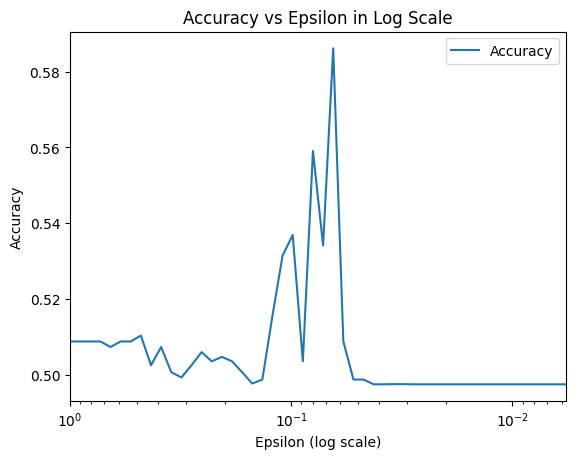

In [8]:
# plot
plt.plot(eps, rands, label='Rand Score')
plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Epsilon (log scale)')
plt.ylabel('Rand Score')
plt.title('Rand Score vs Epsilon in Log Scale')
plt.xlim(eps[0], eps[-1])
plt.legend()
plt.show()


In [15]:
# We test NMF for different magnitudes of noise and outliers
nb_clusters = 2

# You can remove some values to improve execution speed
sigmas = [0, 0.0002, 0.0006, 0.001, 0.002, 0.003, 0.005]
outlier_magnitudes = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]

results = np.zeros(shape=(len(sigmas), len(outlier_magnitudes)))

ep = eps[idx]

for i, sigma in enumerate(sigmas):
    for j, magn in enumerate(outlier_magnitudes):
        data_corrupted = add_noise(data, sigma=sigma)
        data_corrupted = add_outliers(data_corrupted, outlier_magnitude=magn)
        
        dist = distance_matrix(data_corrupted)
        dist_n = dist / np.max(dist)
        Anp = epsilon_graph_hard(dist_n, epsilon=ep)        
        W, H, residual = nmf_sklearn(Anp, d=nb_clusters, max_iter=10000)
        
        results[i, j] = rand_score(true_labels, np.argmax(W, axis=1))


took 35.63
took 34.80
took 34.49
took 34.38
took 34.75
took 34.80
took 34.52
took 34.60
took 34.35
took 36.05
took 36.16
took 36.12
took 36.29
took 36.29
took 36.33
took 36.28
took 36.27
took 36.32
took 36.06
took 36.07
took 36.21
took 36.20
took 36.17
took 36.20
took 36.19
took 36.31
took 36.30
took 36.23
took 36.19
took 36.14
took 36.26
took 36.28
took 36.52
took 36.27
took 36.51
took 36.32
took 36.18
took 36.26
took 36.29
took 36.39
took 36.27
took 36.27
took 36.30
took 36.32
took 36.35
took 36.34
took 36.39
took 36.44
took 36.46
took 36.41
took 36.38
took 36.38
took 36.38
took 36.48
took 36.58
took 36.51
took 36.48
took 36.76
took 36.54
took 36.66
took 36.62
took 36.55
took 36.60


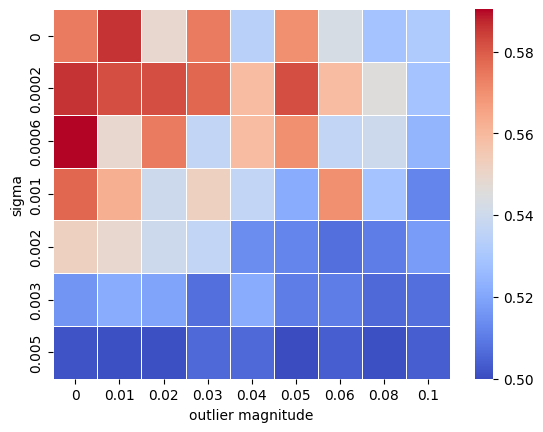

In [19]:
ax = sns.heatmap(results, cmap='coolwarm', linewidth=0.5, xticklabels=outlier_magnitudes, yticklabels=sigmas)
plt.ylabel('sigma')
plt.xlabel('outlier magnitude')
#plt.savefig('noise_smallparam.pdf')
plt.show()